<a href="https://colab.research.google.com/github/ebagdasa/federated/blob/master/analytics/location_heatmaps/dp_location_heatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Location Heatmaps under Distributed Differential Privacy with Secure Aggregation

This code shows examples of the proposed algorithm. We use publicly available [map](https://www.nytimes.com/2018/12/14/reader-center/phone-data-location-investigation.html) from the NYTimes article and population density from [Facebook Humanitarian Data Project](https://data.humdata.org/organization/facebook).


To cite our work use:




In [5]:
!git clone https://github.com/ebagdasa/federated.git

Cloning into 'federated'...
remote: Enumerating objects: 2826, done.
remote: Counting objects: 100% (468/468), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 2826 (delta 350), reused 359 (delta 294), pack-reused 2358
Receiving objects: 100% (2826/2826), 5.19 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (1957/1957), done.


In [6]:
!cd federated/ && git pull

Already up to date.


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
!pip install torch
!pip install matplotlib
!pip install tqdm
!pip install pygtrie

  Created wheel for pygtrie: filename=pygtrie-2.4.2-cp37-none-any.whl size=19063 sha256=000cfe177ba527e11eb5b7926722f45d37782eddbbec03c2b32f6cb8971d58a2
  Stored in directory: /root/.cache/pip/wheels/db/57/91/73782136379fe419036c5ec0e4070d8b3a35f2a36bd6a94ed8
Successfully built pygtrie


In [9]:
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm

In [10]:
import sys
sys.path.insert(1, "federated/analytics/location_heatmaps")

In [11]:
from run_experiment import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import geo_utils
import metrics
import mechanisms

In [ ]:
# Original source:
# !wget https://static01.nyt.com/images/2018/12/14/business/10location-insider/10location-promo-superJumbo-v2.jpg

!wget https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/location_heatmap.jpg

--2021-07-04 14:42:49--  https://www.cs.cornell.edu/~eugene/assets/images/location_heatmap.jpg
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924651 (4.7M) [image/jpeg]
Saving to: ‘location_heatmap.jpg.1’

location_heatmap.jp 100%[===================>]   4.70M  8.09MB/s    in 0.6s    

2021-07-04 14:42:50 (8.09 MB/s) - ‘location_heatmap.jpg.1’ saved [4924651/4924651]



In [ ]:
true_image, dataset = get_data('location_heatmap.jpg')

In [ ]:
print(f'Total users on the map: {true_image.sum():,}.')

Total users on the map: 54,599,988.


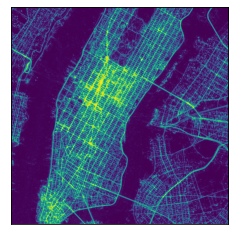

In [ ]:
fig, ax = plt.subplots()
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(true_image)

## Algorithm design

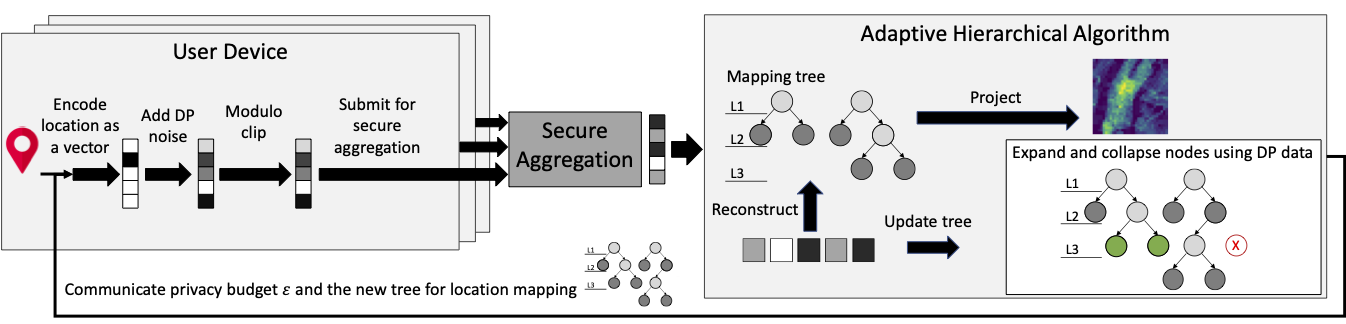

Briefly, our algorithm iteratively explores regions collapsing and expanding depending on the provided dynamic thresholds. It can also balance the privacy budget depending on the result obtained from the previous round of the algorithm. 

To achieve differential privacy under secure aggregation we use distributed geometric noise (see Section 4). We set SecAgg shard size to 10,000.

### No DP

We begin with a sample run, with 10k

positivity: False
Total of 10.0 SecAgg rounds per level


 12%|█▏        | 1183/10000 [00:00<00:00, 11818.04it/s]

Level: 0. Eps: None. Threshold: 10.00. Remaining: 0.00


 10%|▉         | 996/10000 [00:00<00:00, 9953.36it/s]

Level: 0. MSE: 9.66e-11, without sampling error: 1.35e-12.
Level: 1. Eps: None. Threshold: 10.00. Remaining: 0.00


  9%|▉         | 931/10000 [00:00<00:00, 9307.72it/s]

Level: 1. MSE: 9.63e-11, without sampling error: 1.09e-12.
Level: 2. Eps: None. Threshold: 10.00. Remaining: 0.00


  9%|▊         | 862/10000 [00:00<00:01, 8615.74it/s]

Level: 2. MSE: 9.61e-11, without sampling error: 8.85e-13.
Level: 3. Eps: None. Threshold: 10.00. Remaining: 0.00


 10%|▉         | 971/10000 [00:00<00:00, 9708.34it/s]

Level: 3. MSE: 9.60e-11, without sampling error: 7.87e-13.
Level: 4. Eps: None. Threshold: 10.00. Remaining: 0.00


  7%|▋         | 722/10000 [00:00<00:01, 7214.62it/s]

Level: 4. MSE: 9.58e-11, without sampling error: 7.77e-13.
Level: 5. Eps: None. Threshold: 10.00. Remaining: 0.00


  7%|▋         | 712/10000 [00:00<00:01, 7117.48it/s]

Level: 5. MSE: 9.57e-11, without sampling error: 9.32e-13.
Level: 6. Eps: None. Threshold: 10.00. Remaining: 0.00


Level: 6. MSE: 9.58e-11, without sampling error: 9.52e-13.
Finished expanding, no new results.
Total epsilon-users: 0.00 with 0.00 eps per person. 


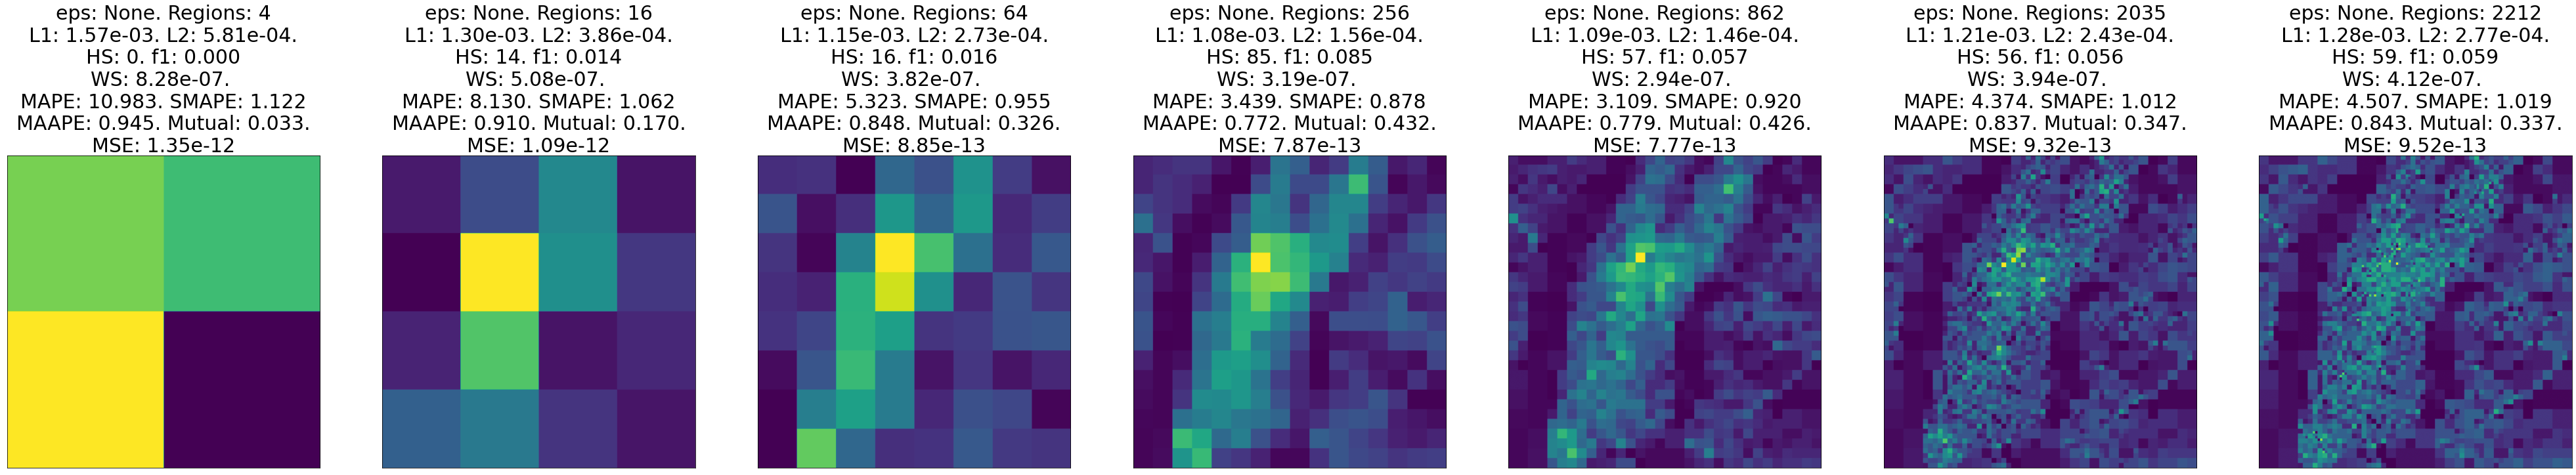

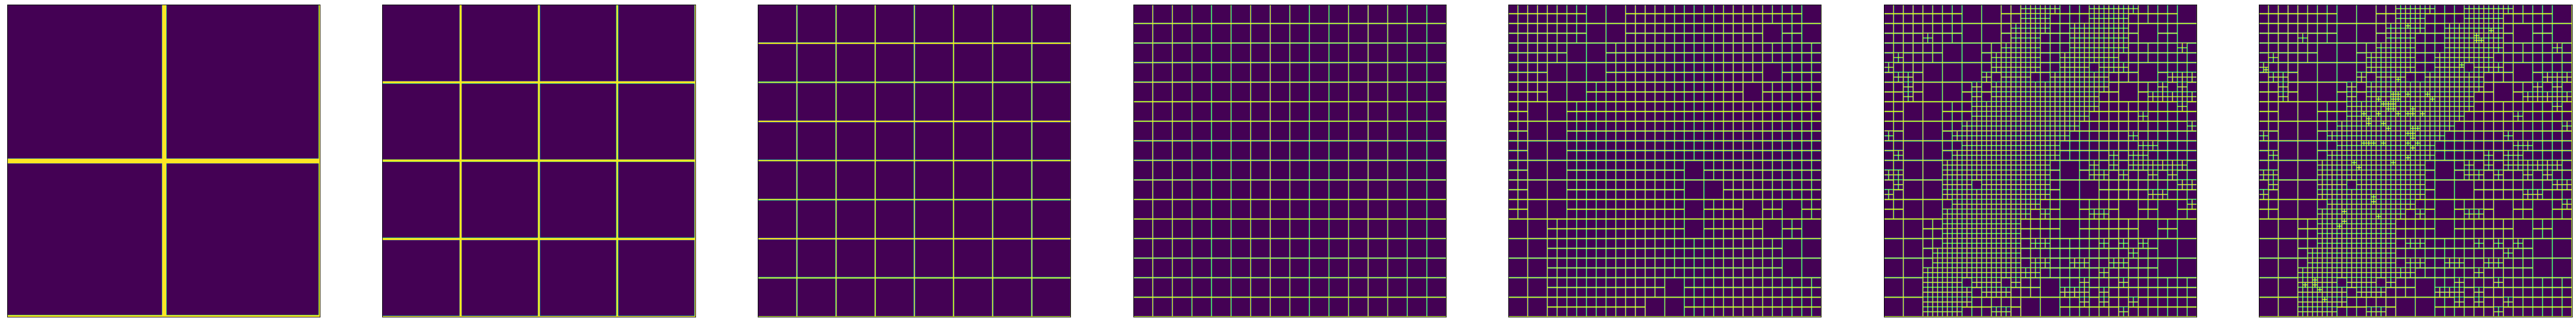

In [ ]:
users = 10000
secagg_size = 1000
c = secagg_size / users
res10_nodp = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: None,
                   threshold=10,
                   top_k=TOPK,
                   partial=1,
                   max_levels=7,
                   total_size=TOTAL_SIZE,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)

In [ ]:
len(res10_nodp)

7

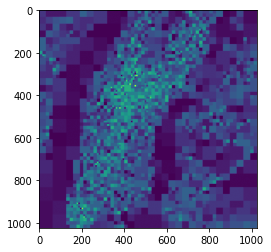

In [ ]:
plt.imshow(res10_nodp[-1].image)

## Algorithm 2

For each level of the algorithm we use method `get_eps_from_two_std()` that computes budget using Equation 8, i.e. it assures that the produced noise is proportional to an approximate ratio of users to a number of sub-regions.

```python
mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions)
```

10k users (no dropout)

positivity: False
Total of 1.0 SecAgg rounds per level


  0%|          | 0/10000 [00:00<?, ?it/s]

Level: 0. Eps: 0.01131364816007492. Threshold: 10.00. Remaining: 1.00


  9%|▉         | 894/10000 [00:00<00:01, 8939.09it/s]

Level: 0. MSE: 9.65e-11, without sampling error: 1.35e-12.
Level: 1. Eps: 0.04525097313957988. Threshold: 10.00. Remaining: 0.99


  6%|▌         | 564/10000 [00:00<00:01, 5636.70it/s]

Level: 1. MSE: 9.63e-11, without sampling error: 1.09e-12.
Level: 2. Eps: 0.18077309093243188. Threshold: 10.00. Remaining: 0.94


  4%|▍         | 401/10000 [00:00<00:02, 3545.80it/s]

Level: 2. MSE: 9.61e-11, without sampling error: 8.86e-13.
Last round. Spending remaining epsilon budget: 7626.622877679133
Level: 3. Eps: 0.7626622877679133. Threshold: 10.00. Remaining: 0.76


Level: 3. MSE: 9.59e-11, without sampling error: 7.89e-13.
Total epsilon-users: 10000.00 with 1.00 eps per person. 


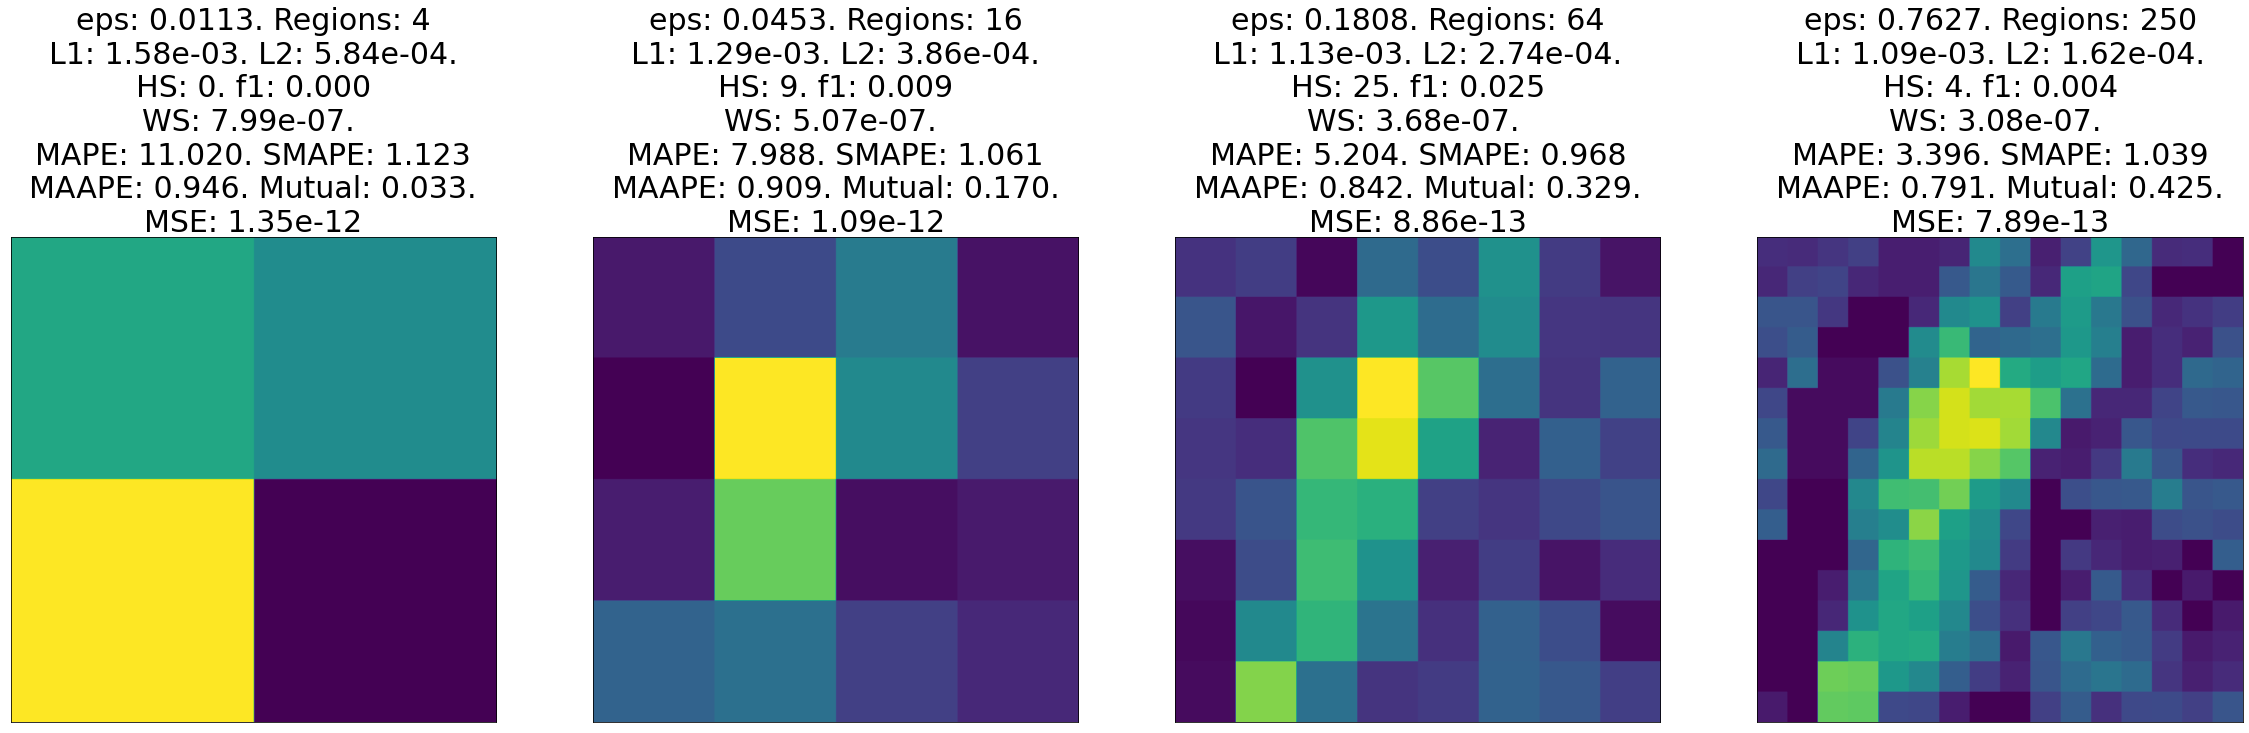

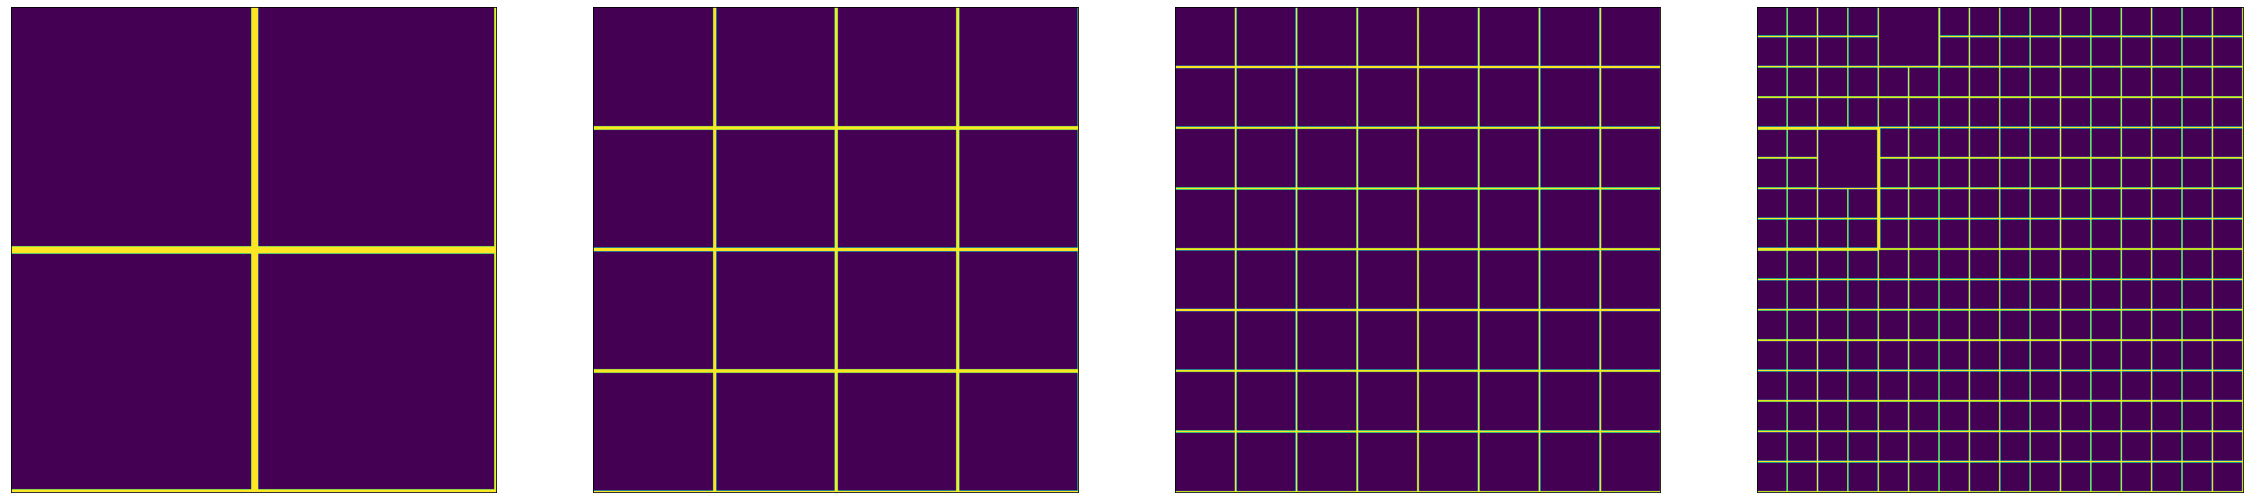

In [ ]:
users = 10000
secagg_size = 10000
c = 1/10
res10k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)


### 100K users with 10% dropout and distributed DP

positivity: False
Total of 10.0 SecAgg rounds per level


  1%|          | 926/100000 [00:00<00:10, 9256.30it/s]

Level: 0. Eps: 0.003577706855891111. Threshold: 10.00. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. MSE: 1.09e-11, without sampling error: 1.35e-12.
Level: 1. Eps: 0.014310712939686405. Threshold: 10.00. Remaining: 1.00


Level: 1. MSE: 1.06e-11, without sampling error: 1.09e-12.
Level: 2. Eps: 0.05723552747969013. Threshold: 10.00. Remaining: 0.98


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 2. MSE: 1.04e-11, without sampling error: 8.82e-13.
Level: 3. Eps: 0.22847608844135425. Threshold: 10.00. Remaining: 0.92


Level: 3. MSE: 1.03e-11, without sampling error: 7.67e-13.


  0%|          | 101/100000 [00:00<02:10, 764.39it/s]

Last round. Spending remaining epsilon budget: 69639.9964283378
Level: 4. Eps: 0.696399964283378. Threshold: 10.00. Remaining: 0.70


Level: 4. MSE: 1.02e-11, without sampling error: 7.01e-13.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


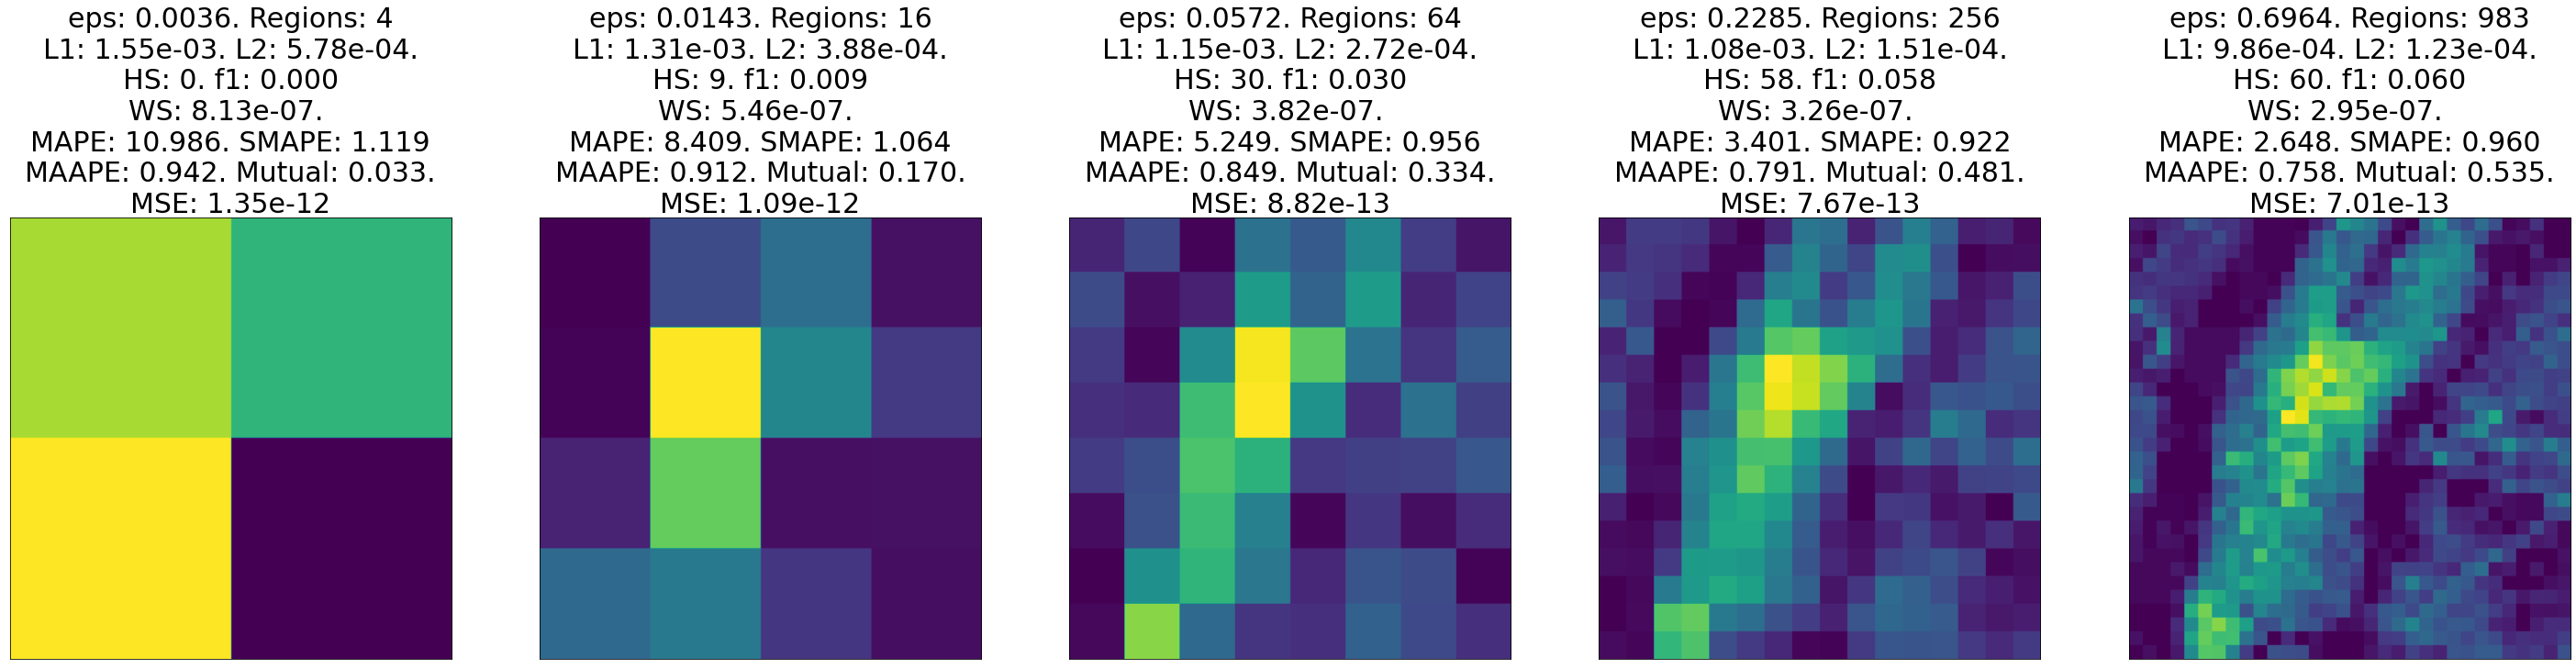

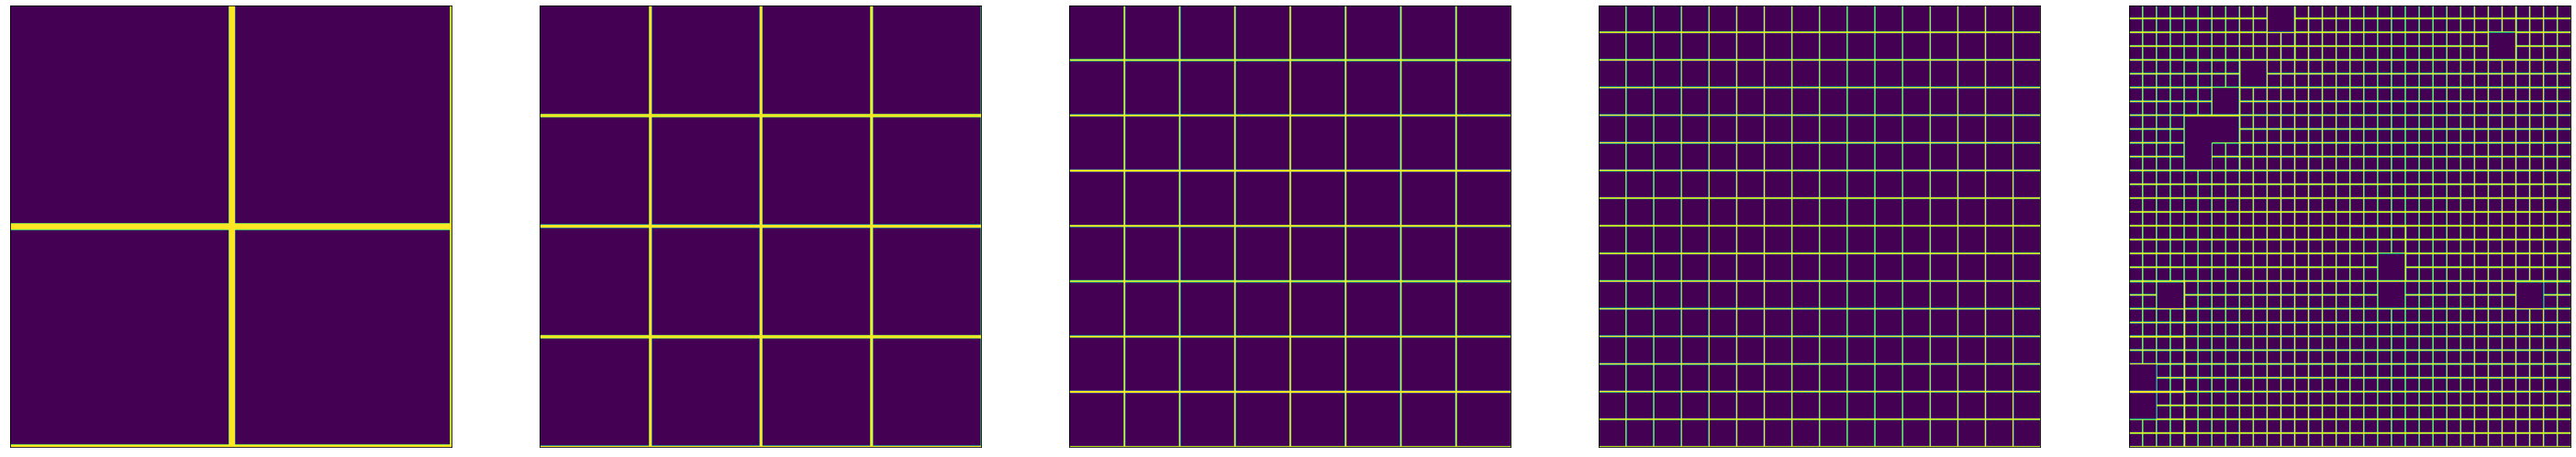

In [ ]:
users = 100000
secagg_size = 10000
c = 1/10
res100k = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   min_dp_size=9000,
                   dropout_rate=0.1,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)


In [ ]:
plotting.animate_gif(res100k)

due to dropout less reported data for level: 0.
due to dropout less reported data for level: 0.
due to dropout less reported data for level: 2.
due to dropout less reported data for level: 2.
due to dropout less reported data for level: 2.
due to dropout less reported data for level: 3.
due to dropout less reported data for level: 3.
due to dropout less reported data for level: 3.
due to dropout less reported data for level: 4.
due to dropout less reported data for level: 4.
due to dropout less reported data for level: 4.


<Figure size 432x288 with 0 Axes>

positivity: False
Total of 100.0 SecAgg rounds per level


  0%|          | 1090/1000000 [00:00<01:31, 10894.58it/s]

Level: 0. Eps: 0.0011313707895586728. Threshold: 10.00. Remaining: 1.00


Level: 0. MSE: 2.29e-12, without sampling error: 1.35e-12.


  0%|          | 1075/1000000 [00:00<01:32, 10746.30it/s]

Level: 1. Eps: 0.00452547953785703. Threshold: 10.00. Remaining: 1.00


Level: 1. MSE: 2.03e-12, without sampling error: 1.09e-12.


  0%|          | 801/1000000 [00:00<02:07, 7819.00it/s]

Level: 2. Eps: 0.018101686455752795. Threshold: 10.00. Remaining: 0.99


Level: 2. MSE: 1.82e-12, without sampling error: 8.82e-13.


  0%|          | 401/1000000 [00:00<04:15, 3907.33it/s]

Level: 3. Eps: 0.07239192600495825. Threshold: 10.00. Remaining: 0.98


Level: 3. MSE: 1.70e-12, without sampling error: 7.63e-13.


  0%|          | 101/1000000 [00:00<18:39, 892.90it/s]

Level: 4. Eps: 0.28526856439496157. Threshold: 10.00. Remaining: 0.90


Level: 4. MSE: 1.62e-12, without sampling error: 6.86e-13.


  0%|          | 0/1000000 [00:00<?, ?it/s]

Last round. Spending remaining epsilon budget: 618580.9728169116
Level: 5. Eps: 0.6185809728169116. Threshold: 10.00. Remaining: 0.62


Level: 5. MSE: 1.54e-12, without sampling error: 6.13e-13.
Total epsilon-users: 1000000.00 with 1.00 eps per person. 


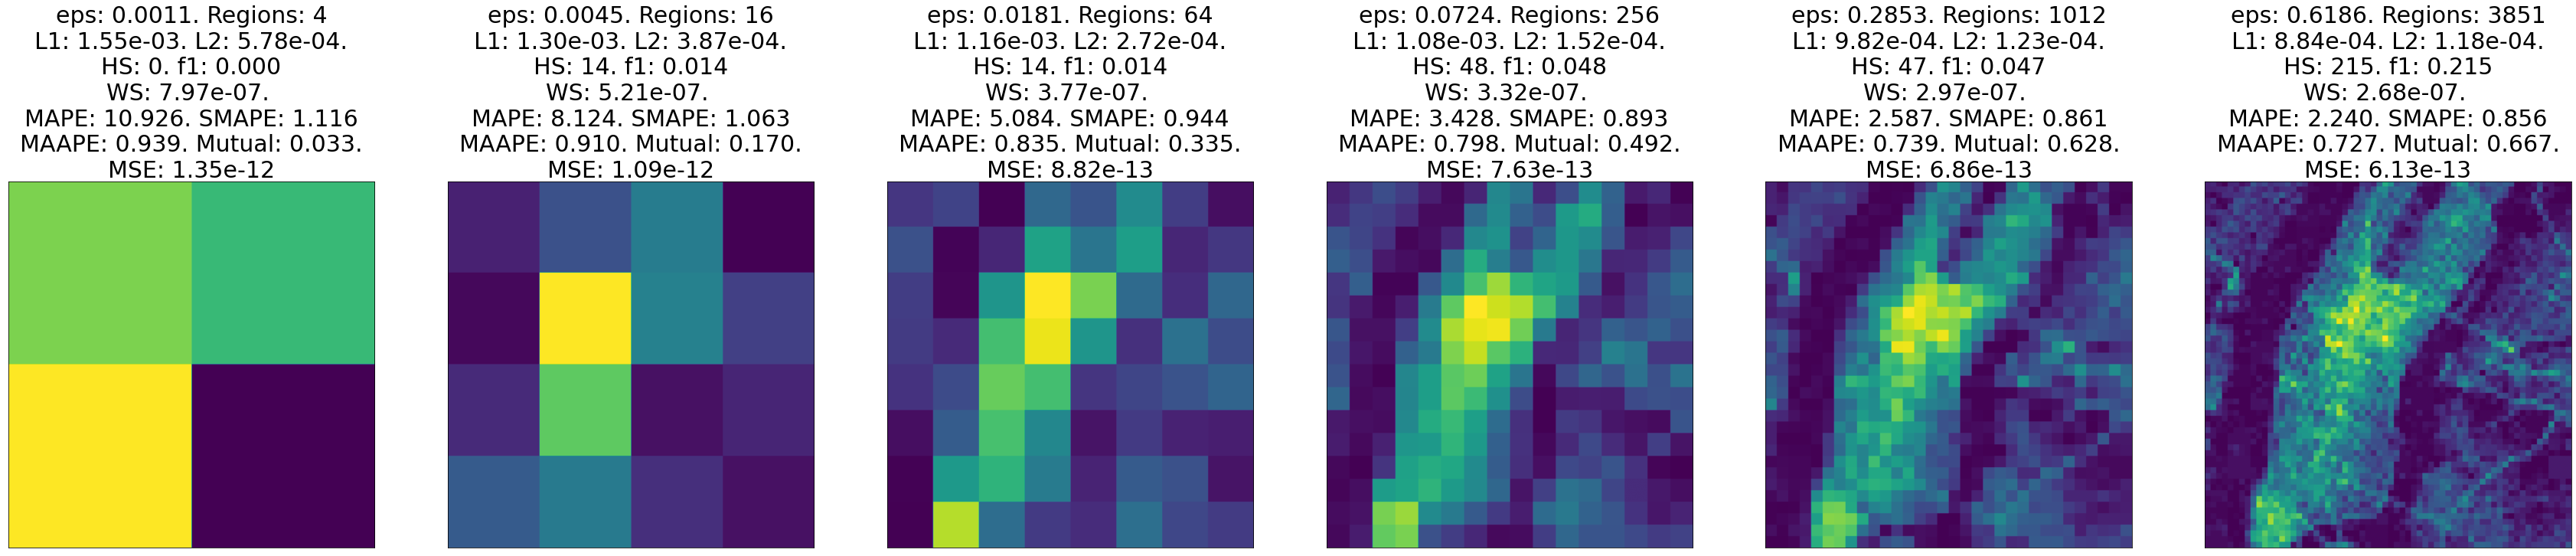

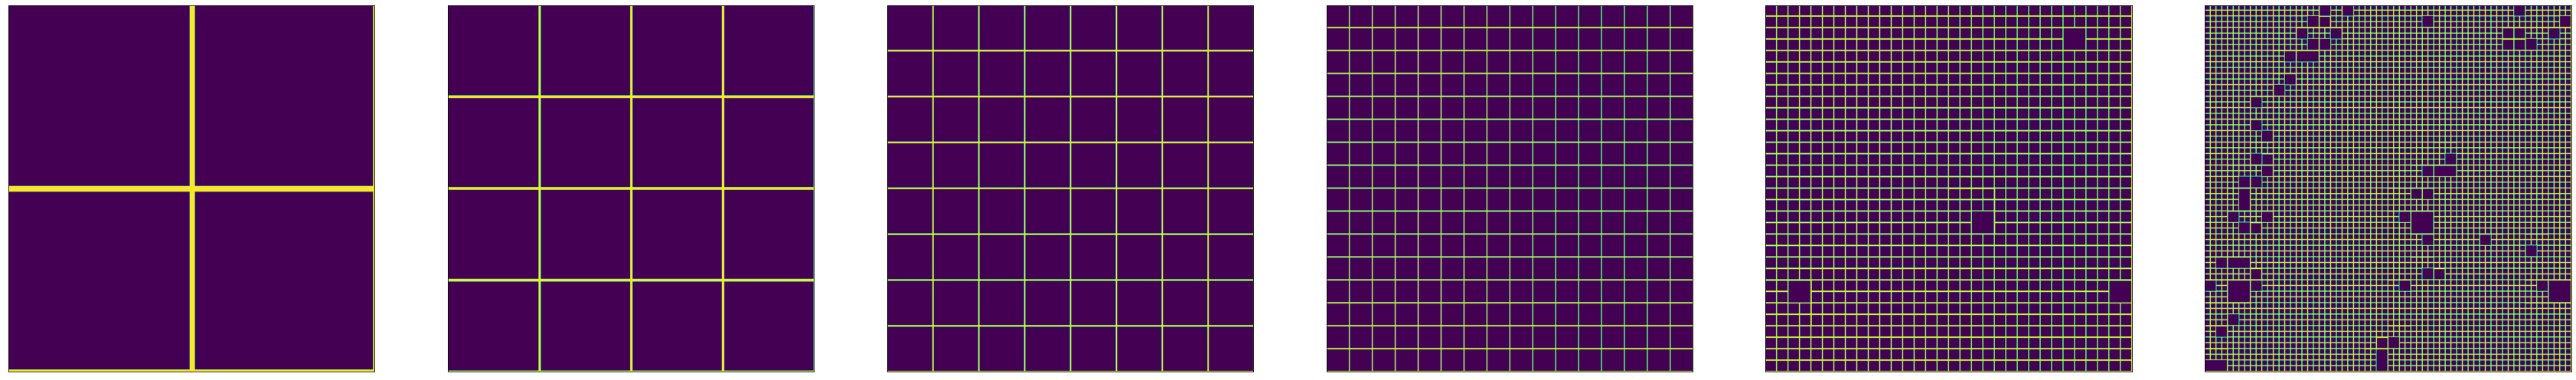

In [ ]:
users = 1000000
secagg_size = 10000
c = 1/10
res1mln = run_experiment(true_image,
                   dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(c * np.sqrt(secagg_size / users) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 10,
                   collapse_func=lambda threshold: max(5, 1/4 * threshold),
                       total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=TOTAL_SIZE,
                   min_dp_size=9000,
                   dropout_rate=0.1,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)


# Adding more data

In [ ]:
split_dataset = geo_utils.makeGaussian(true_image, 1024, 500, [200, 900], convert=True, save=True, load=False)


100%|██████████| 1024/1024 [00:14<00:00, 69.42it/s] 


Saved to split_dataset_500_200_900.pt


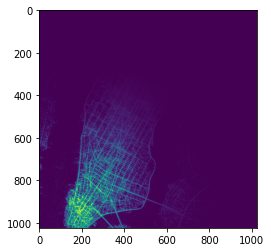

In [ ]:
plt.imshow(split_dataset['pos_image'])

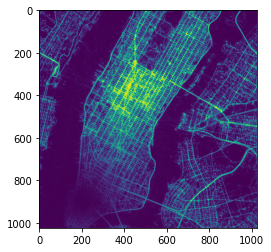

In [ ]:
plt.imshow(split_dataset['neg_image'])

# Different datasets

In [3]:
!wget https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/lagos.np
!wget https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/mayotte.np

--2021-07-12 17:04:26--  https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/lagos.np
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33555055 (32M)
Saving to: ‘lagos.np.1’

lagos.np.1          100%[===================>]  32.00M  23.3MB/s    in 1.4s    

2021-07-12 17:04:28 (23.3 MB/s) - ‘lagos.np.1’ saved [33555055/33555055]

--2021-07-12 17:04:28--  https://www.cs.cornell.edu/~eugene/assets/projects/location_heatmaps/mayotte.np
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10486383 (10M)
Saving to: ‘mayotte.np.1’

mayotte.np.1        100%[===================>]  10.00M  13.1MB/s    in 0.8s    

2021-07-12 17:04:30 (13.1 MB/s) - ‘mayotte.np.1’ sav

In [12]:
mt = torch.load('mayotte.np')
lagos = torch.load('lagos.np')

lagos = lagos[1000:2024, 200:1224]
mt = mt[128:1152, :]

In [13]:
lagos_dataset = geo_utils.convert_to_dataset(lagos, total_size=1024)
mt_dataset = geo_utils.convert_to_dataset(mt, total_size=1024)

100%|██████████| 1024/1024 [00:00<00:00, 1907.44it/s]


  0%|          | 0/100000 [00:00<?, ?it/s]

positivity: False
Total of 10.0 SecAgg rounds per level
Level: 0. Eps: 0.003577706855891111. Threshold: 8.62. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. MSE: 5.49e-11, without sampling error: 4.93e-11.
Level: 1. Eps: 0.014310712939686405. Threshold: 8.75. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 1. MSE: 5.41e-11, without sampling error: 4.85e-11.
Level: 2. Eps: 0.0482943748761969. Threshold: 9.24. Remaining: 0.98


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 2. MSE: 5.25e-11, without sampling error: 4.69e-11.
Level: 3. Eps: 0.17597500813930209. Threshold: 11.52. Remaining: 0.93


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 3. MSE: 4.90e-11, without sampling error: 4.34e-11.
Last round. Spending remaining epsilon budget: 75784.21971889236
Level: 4. Eps: 0.7578421971889236. Threshold: 11.52. Remaining: 0.76


Level: 4. MSE: 4.54e-11, without sampling error: 3.98e-11.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


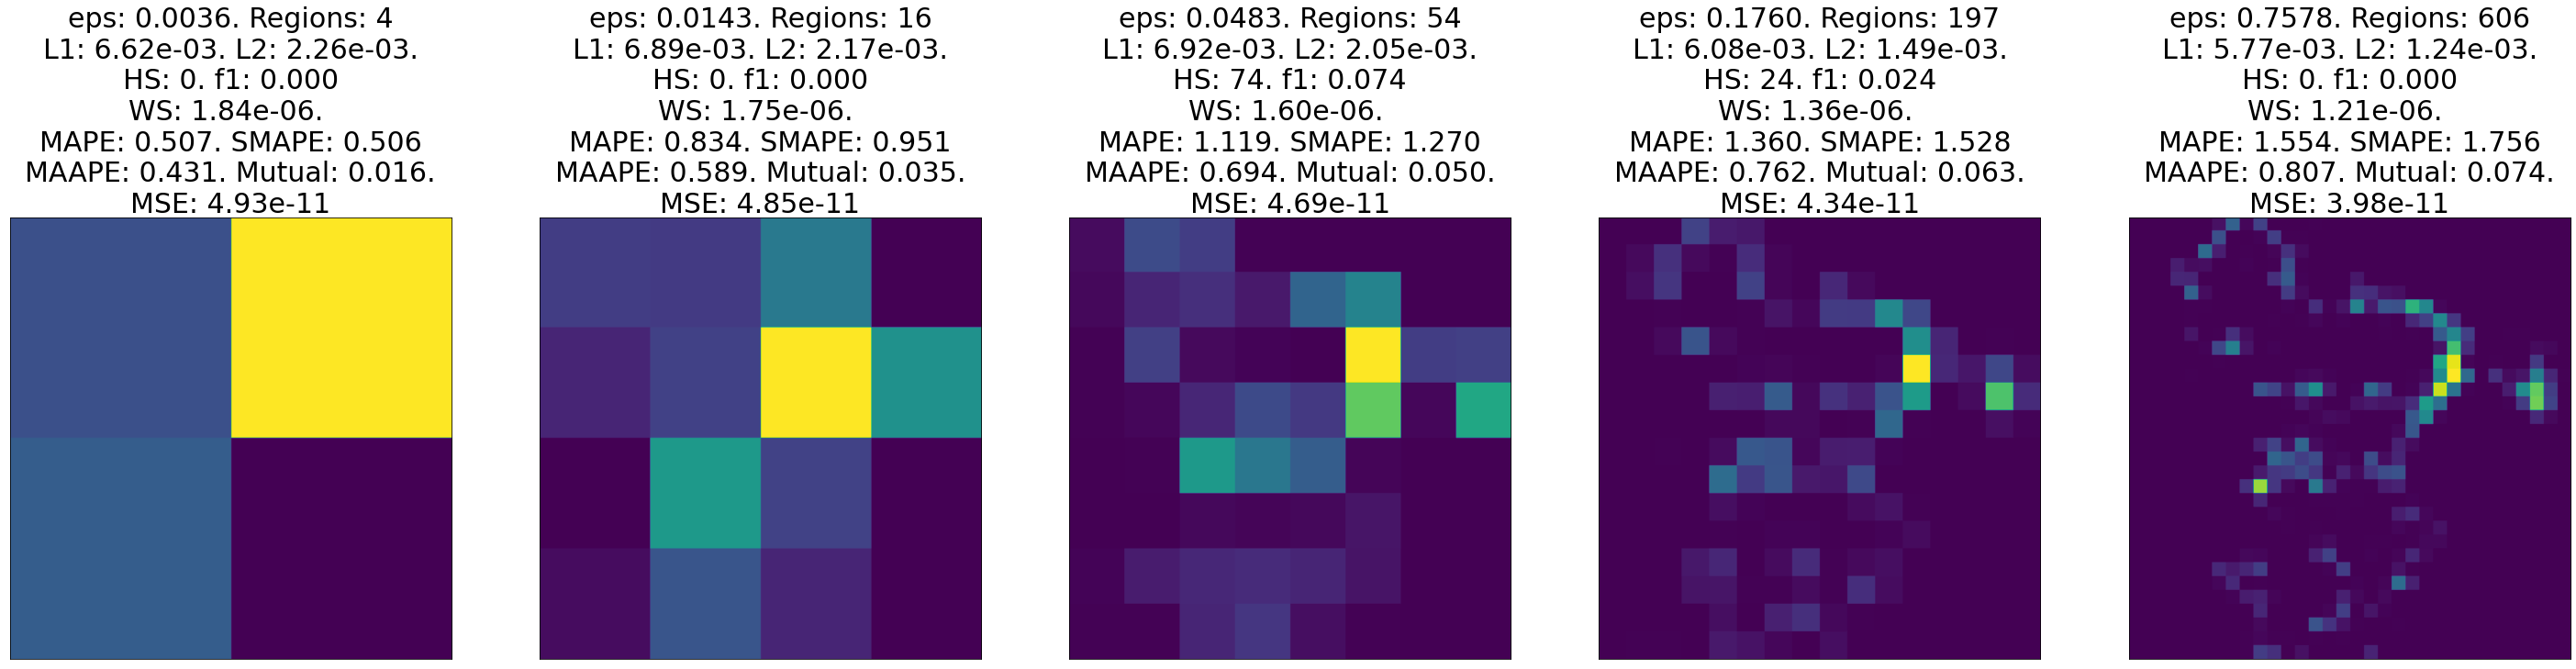

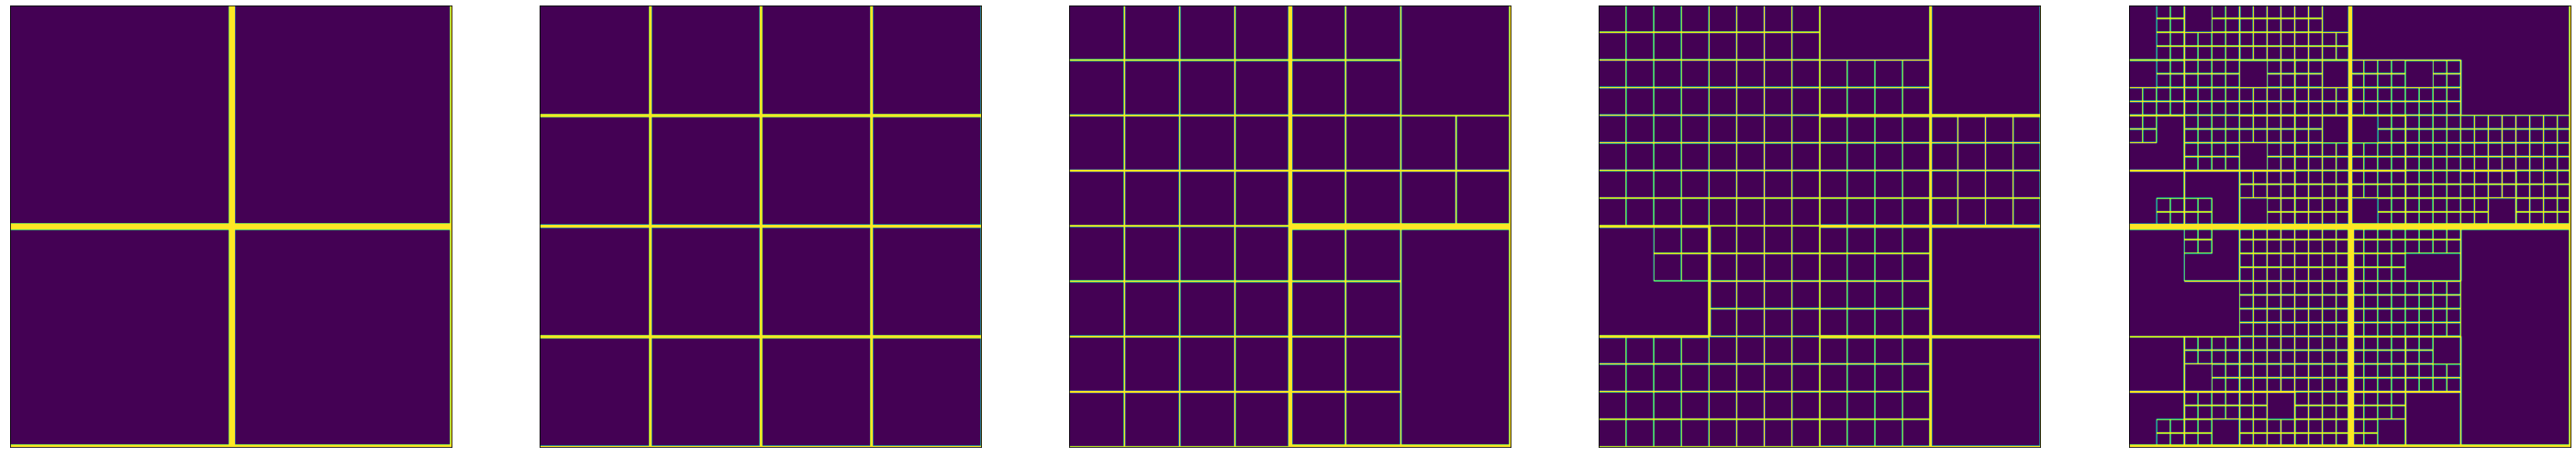

In [14]:
          
users = 100000
secagg_size = 10000
c = secagg_size / users
res10 = run_experiment(mt,
                   mt_dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(1/10 * np.sqrt(c) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(c) * mechanisms.get_std_from_eps( max(eps, remaining)),
                   collapse_func=lambda threshold: threshold,
                   total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=1024,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)

positivity: False
Total of 10.0 SecAgg rounds per level


  1%|          | 916/100000 [00:00<00:10, 9156.86it/s]

Level: 0. Eps: 0.003577706855891111. Threshold: 8.62. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 0. MSE: 1.22e-11, without sampling error: 4.95e-11.
Level: 1. Eps: 0.014310712939686405. Threshold: 8.75. Remaining: 1.00


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 1. MSE: 1.17e-11, without sampling error: 4.94e-11.
Level: 2. Eps: 0.05723552747969013. Threshold: 9.33. Remaining: 0.98


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 2. MSE: 1.14e-11, without sampling error: 4.97e-11.
Level: 3. Eps: 0.21158434856951708. Threshold: 12.28. Remaining: 0.92


  0%|          | 0/100000 [00:00<?, ?it/s]

Level: 3. MSE: 1.12e-11, without sampling error: 5.01e-11.
Last round. Spending remaining epsilon budget: 71329.17041552153
Level: 4. Eps: 0.7132917041552153. Threshold: 12.28. Remaining: 0.71


Level: 4. MSE: 1.09e-11, without sampling error: 5.04e-11.
Total epsilon-users: 100000.00 with 1.00 eps per person. 


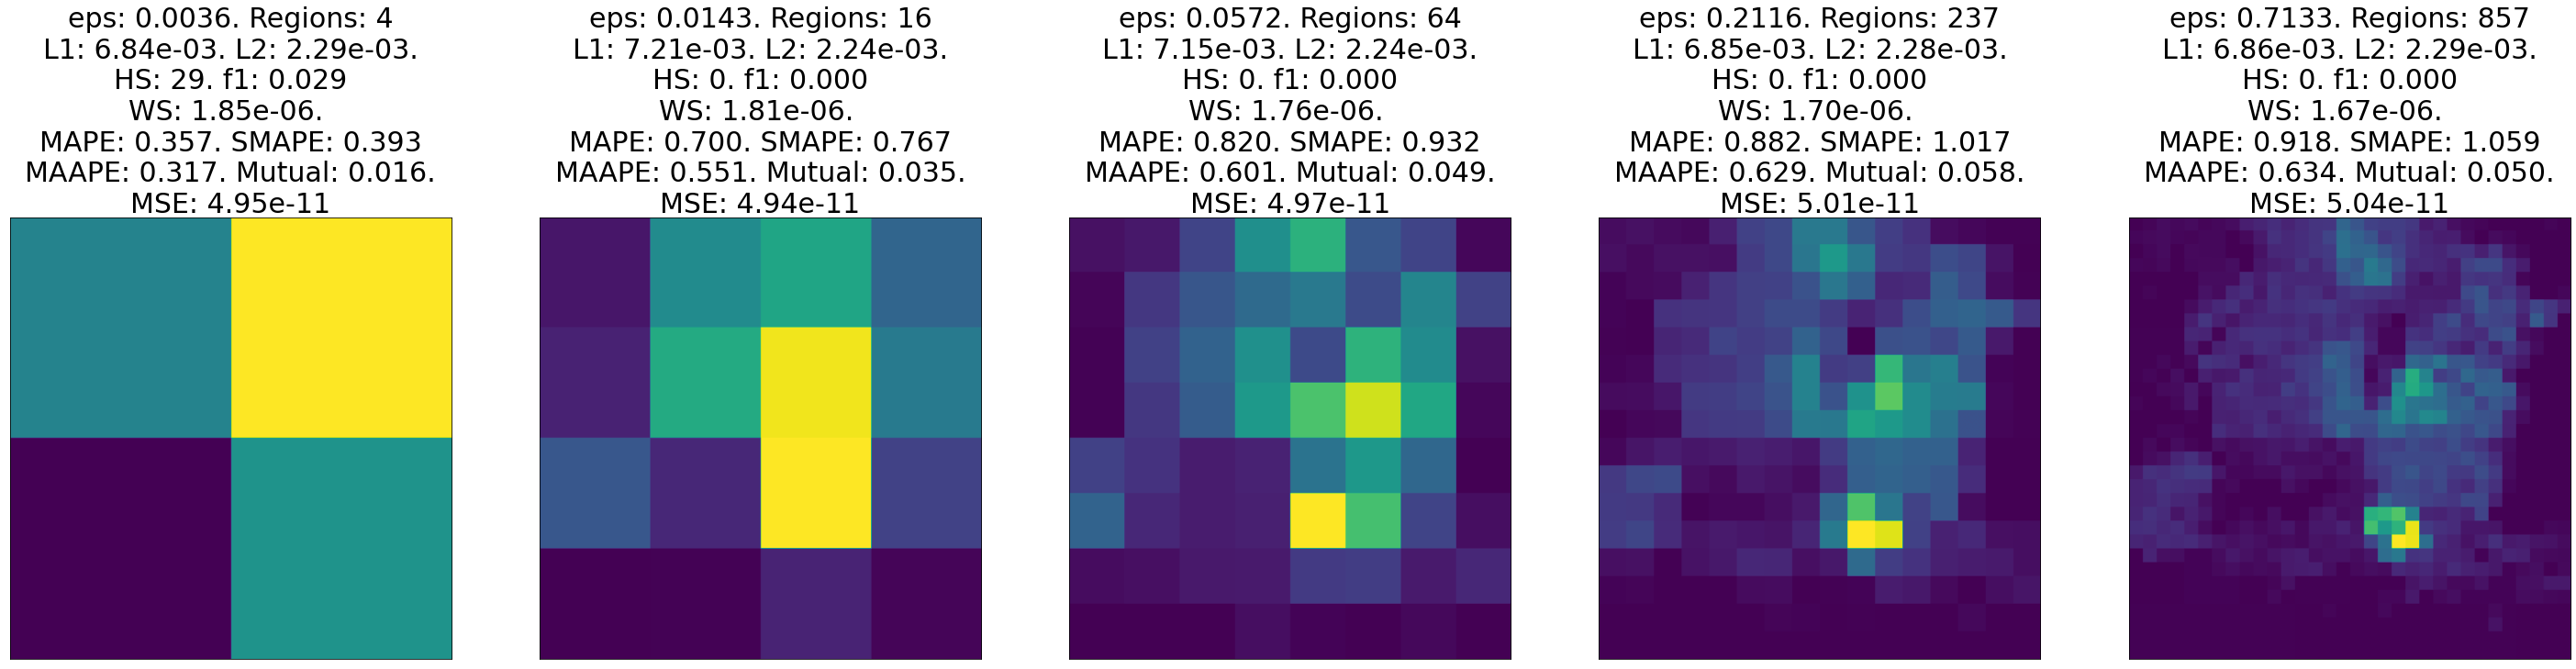

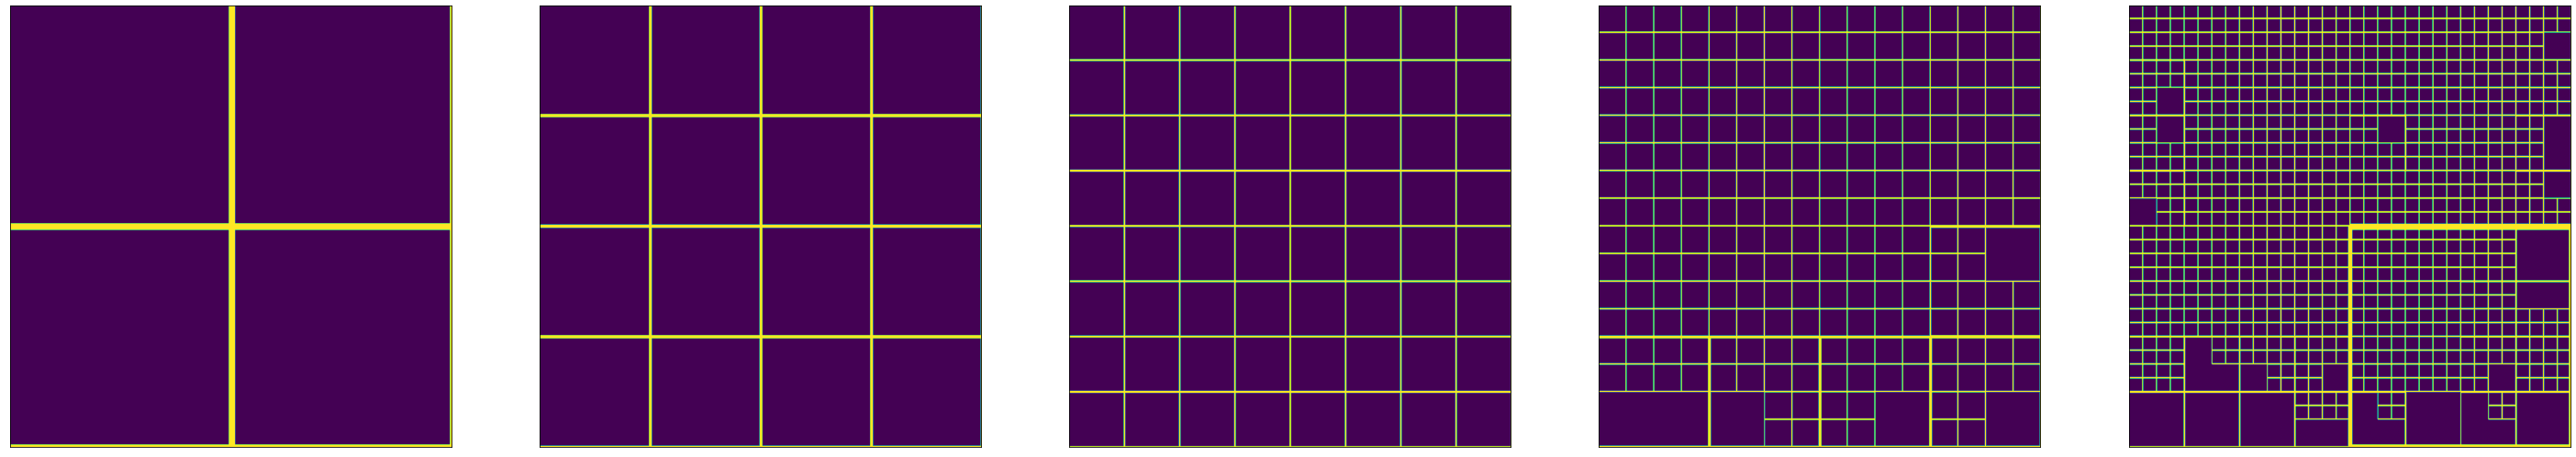

In [15]:
          
users = 100000
secagg_size = 10000
c = secagg_size / users
res10 = run_experiment(lagos,
                   lagos_dataset,
                   level_sample_size=users,
                   secagg_round_size=secagg_size,
                   eps_func=lambda x, num_regions: mechanisms.get_eps_from_two_std(1/10 * np.sqrt(c) * users/num_regions),
                   threshold_func=lambda i, prefix_len, eps, remaining: 2 / np.sqrt(c) * mechanisms.get_std_from_eps( max(eps, remaining)),
                   collapse_func=lambda threshold: threshold,
                   total_epsilon_budget=1*users,
                   top_k=TOPK,
                   partial=100,
                   max_levels=10,
                   total_size=1024,
                   min_dp_size=None,
                   dropout_rate=None,
                   output_flag=True,
                   quantize=None,
                   save_gif=False,
                   positivity=False, start_with_level=-1,
                   last_result_ci=False)